In [5]:
# from openai import OpenAI
import openai
from time import sleep
from functools import cache

EMBED_MODEL = "text-embedding-ada-002"

@cache
def create_embeddings(texts):
    try:
        res = openai.Embedding.create(input=texts, engine=EMBED_MODEL)                    
    except Exception as e:
        print(e)
        done = False
        while not done:
            sleep(5)
            try:
                res = openai.Embedding.create(input=texts, engine=EMBED_MODEL)
                done = True           
            except Exception as e:
                print(e)
                pass
    return res['data'][0]['embedding']
    try:
        res = client.embeddings.create(
            input=texts,
            model=EMBED_MODEL
        )    
    except Exception as e:
        print(e)
        done = False
        while not done:
            sleep(5)
            try:
                res = client.embeddings.create(
                    input=texts,
                    model=EMBED_MODEL
                )    
                done = True
            except:
                pass
    return res.data[0].embedding

print(create_embeddings("Hello world!"))

[0.006586113478988409, 0.003723542205989361, -0.01170794852077961, -0.026796935126185417, -0.012392953969538212, -0.001363727729767561, -0.01342360582202673, 0.009395266883075237, -0.006344161927700043, -0.029486684128642082, 0.024006634950637817, 0.0030291094444692135, -0.0232147928327322, -0.009156457148492336, 0.006774647627025843, 0.0011885483982041478, 0.026042800396680832, -0.018350621685385704, 0.008936501108109951, 0.009634076617658138, -0.013059106655418873, -0.0011021371465176344, 0.007201990578323603, 0.008747967891395092, -0.012663185596466064, 0.0036324176471680403, 0.005461195483803749, -0.017282264307141304, 0.03634931519627571, -0.026721522212028503, 0.012619194574654102, -0.008578287437558174, -0.007654471788555384, -0.012581488117575645, 0.0070574479177594185, -0.014140034094452858, 0.004923874046653509, -0.013599570840597153, 0.018187226727604866, -0.014378843829035759, 0.008326908573508263, 0.006014227867126465, 0.0055114710703492165, -0.006347304210066795, -0.03612

In [14]:
import pandas as pd

df = pd.read_csv('NAICS descriptions.csv')
embeds = []

for sector, definition, decscription in zip(df['Sector'], df['Definition'], df['Descriptions']):
    embeds.append({
        'label': sector,
        'definition': definition,
        'embed': create_embeddings(f'{definition} {decscription}')
    })

In [15]:
import pinecone

index_name = 'dc-github'

pinecone.init(
    api_key=, # jayyeungscout account
    environment='gcp-starter'
)

if index_name not in pinecone.list_indexes():
    sample_embedding = create_embeddings("Sample document text")
    print(f'Creating {index_name} index')
    pinecone.create_index(
        index_name,
        dimension=len(sample_embedding),
        metric='cosine'
    )
    print('Done')
else:
    print(f'Connecting to existing {index_name} index')

index = pinecone.Index(index_name=index_name)  # Store the index object as an attribute
print(pinecone.describe_index(index_name))

/opt/homebrew/lib/python3.11/site-packages/pinecone/index.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Connecting to existing dc-github index
IndexDescription(name='dc-github', metric='cosine', replicas=1, dimension=1536.0, shards=1, pods=1, pod_type='starter', status={'ready': True, 'state': 'Ready'}, metadata_config=None, source_collection='')


In [4]:
test = '''
farmOS is a web-based application for farm management, planning, and record keeping. It is developed by a community of volunteers and aims to provide a standard platform for farmers, developers, and researchers to build upon.
'''

test_embed = create_embeddings(test)

results = index.query(vector = test_embed, include_metadata = True, top_k=100)

# for i in results['matches']:
#     print(f'{i["metadata"]["label"]} -\t {i["metadata"]["definition"]} -\t {i["score"]}')
#     print('-' * 70)


In [5]:
guess_vector = [[i['score'], i['metadata']['label']] for i in results['matches']]
guess_vector.sort(key = lambda x:x[1])
guess_vector = [i[0] for i in guess_vector]

print(guess_vector)
print(len(guess_vector))

[0.783371329, 0.703009486, 0.696823597, 0.69074, 0.688499212, 0.688310862, 0.685994625, 0.686323822, 0.680723429, 0.688168526, 0.699573398, 0.701931953, 0.725258231, 0.695917428, 0.69463, 0.691345274, 0.707400262, 0.702984035, 0.710824966, 0.713665366]
20


In [6]:
from sklearn.metrics import roc_auc_score
correct = [1, 1] + [0] * 17 + [1]

def test_accuracy(guess_vector, correct):
    # Normalize the guess_vector
    min_val = min(guess_vector)
    max_val = max(guess_vector)
    normalized_guess_vector = [(x - min_val) / (max_val - min_val) for x in guess_vector]

    # Compute AUC-ROC score
    score = roc_auc_score(correct, normalized_guess_vector)
    # print(f"AUC-ROC Score: {score:.2f}")
    return score


In [7]:
import pandas as pd

naics = pd.read_csv("NAICS descriptions.csv")
exam = pd.read_csv("Testing_corpus_descriptions.csv")

predicted_labels = []

for description in exam['Description']:
    description_embed = create_embeddings(description)
    results = index.query(vector=description_embed, include_metadata=True, top_k=20)
    
    guess_vector = [i['score'] for i in sorted(results['matches'], key=lambda x: x['metadata']['label'])]
    top_label = max(results['matches'], key=lambda x: x['score'])['metadata']['label']
    
    predicted_labels.append(top_label)

exam['Predicted_Label'] = predicted_labels

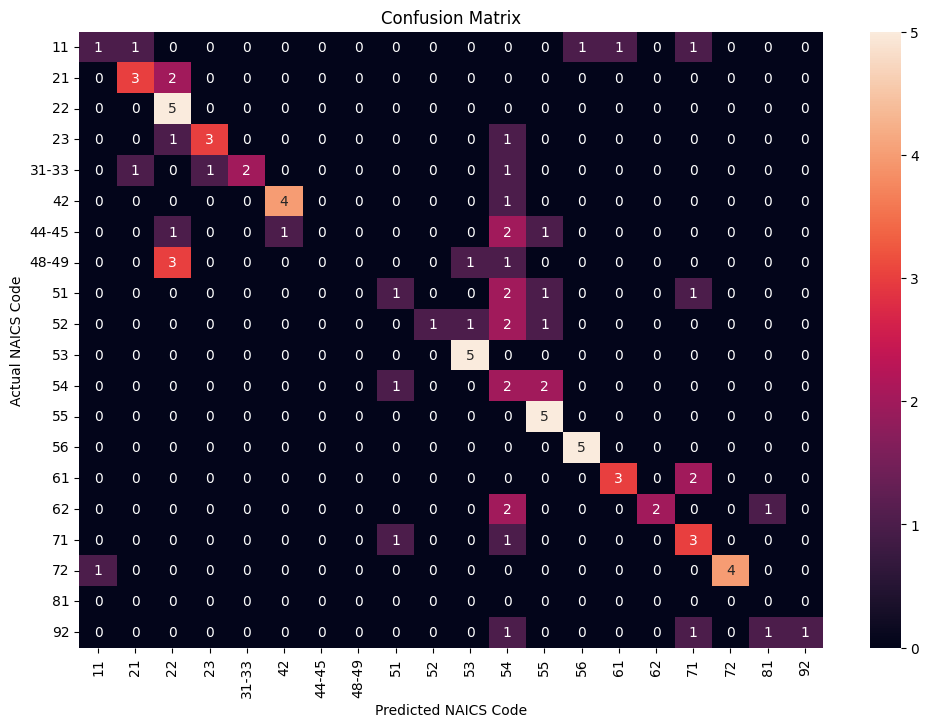

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

unique_labels = sorted(set(exam['Sector'].unique()).union(set(exam['Predicted_Label'].unique())))

cm = confusion_matrix(exam['Sector'], exam['Predicted_Label'], labels=unique_labels)

cm_df = pd.DataFrame(cm, index=unique_labels, columns=unique_labels)

plt.figure(figsize=(12, 8))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual NAICS Code')
plt.xlabel('Predicted NAICS Code')
plt.show()
